In [5]:
import os
import shutil
from pathlib import Path
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
origem = Path('animais')
treino = Path('animais/treino')
validacao = Path('animais/validacao')
aug_treino = Path('aumentadas/treino')
classes = ['aguia', 'cachorro', 'baleia']

In [7]:
# --- Separação das imagens em treino e validação ---
for classe in classes:
    pasta_origem = origem / classe
    arquivos = sorted(os.listdir(pasta_origem))
    treino_classe = treino / classe
    validacao_classe = validacao / classe
    treino_classe.mkdir(parents=True, exist_ok=True)
    validacao_classe.mkdir(parents=True, exist_ok=True)
    for i, arquivo in enumerate(arquivos):
        src = pasta_origem / arquivo
        if i < 9:
            shutil.copy(src, treino_classe / arquivo)
        else:
            shutil.copy(src, validacao_classe / arquivo)


In [8]:
# --- Data Augmentation apenas no treino ---
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
aug_treino.mkdir(parents=True, exist_ok=True)
for classe in classes:
    input_path = treino / classe
    output_path = aug_treino / classe
    output_path.mkdir(parents=True, exist_ok=True)
    for img_file in os.listdir(input_path):
        img_path = input_path / img_file
        img = load_img(img_path, target_size=(150, 150))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_path, save_prefix=classe, save_format='jpeg'):
            i += 1
            if i >= 50:
                break


In [9]:
# --- Preparação dos dados para Random Forest ---
img_size = (150, 150)
X_train, y_train = [], []
for label, classe in enumerate(classes):
    pasta = aug_treino / classe
    for arquivo in os.listdir(pasta):
        caminho_img = pasta / arquivo
        try:
            img = load_img(caminho_img, target_size=img_size)
            img_array = img_to_array(img)
            img_array = img_array.flatten() / 255.0
            X_train.append(img_array)
            y_train.append(label)
        except:
            print(f"Erro ao carregar {caminho_img}")

X_test, y_test = [], []
for label, classe in enumerate(classes):
    pasta = validacao / classe
    for arquivo in os.listdir(pasta):
        caminho_img = pasta / arquivo
        try:
            img = load_img(caminho_img, target_size=img_size)
            img_array = img_to_array(img)
            img_array = img_array.flatten() / 255.0
            X_test.append(img_array)
            y_test.append(label)
        except:
            print(f"Erro ao carregar {caminho_img}")


              precision    recall  f1-score   support

       aguia       1.00      1.00      1.00         3
    cachorro       1.00      0.67      0.80         3
      baleia       0.75      1.00      0.86         3

    accuracy                           0.89         9
   macro avg       0.92      0.89      0.89         9
weighted avg       0.92      0.89      0.89         9

Acurácia: 0.8888888888888888


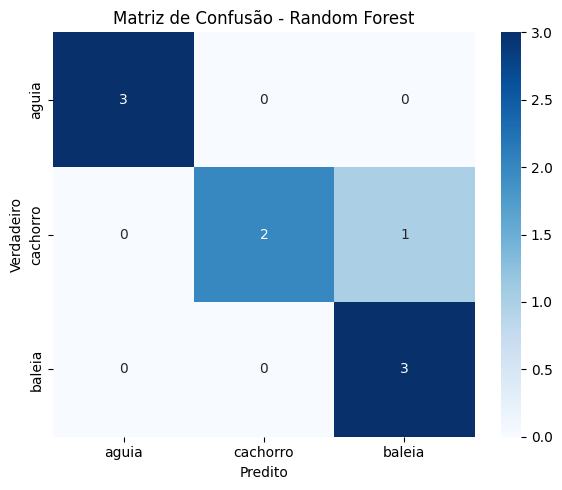

In [10]:
# --- Treinamento e avaliação do Random Forest ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=classes))
print("Acurácia:", accuracy_score(y_test, y_pred))

# --- Matriz de confusão ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Random Forest')
plt.tight_layout()
plt.show()

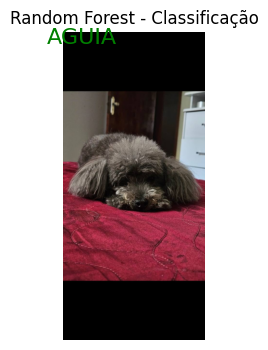

Classe predita: aguia
Caminho da imagem: imgsAmigos/lili2.jpg


In [21]:
# --- Função para classificar uma imagem nova ---
def mostrar_predicao_rf(modelo, caminho_imagem):
    img = load_img(caminho_imagem, target_size=img_size)
    img_array = img_to_array(img).flatten() / 255.0
    img_array = img_array.reshape(1, -1)
    pred = modelo.predict(img_array)
    classe_predita = classes[int(pred[0])]
    plt.figure(figsize=(4, 4))
    plt.imshow(load_img(caminho_imagem))
    plt.axis('off')
    plt.text(75, 50, classe_predita.upper(), fontsize=16, ha='center', color='green')
    plt.title('Random Forest - Classificação')
    plt.show()
    print(f'Classe predita: {classe_predita}')
    print(f'Caminho da imagem: {caminho_imagem}')

# Exemplo de uso:
mostrar_predicao_rf(clf, "imgsAmigos/lili2.jpg")

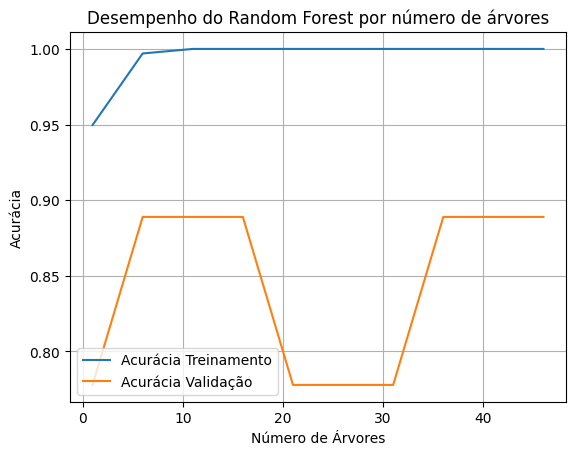

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_arvores = range(1, 50, 5)  # de 1 até 100 árvores, de 5 em 5
train_acc = []
val_acc = []

for n in n_arvores:
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    val_acc.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(n_arvores, train_acc, label='Acurácia Treinamento')
plt.plot(n_arvores, val_acc, label='Acurácia Validação')
plt.xlabel('Número de Árvores')
plt.ylabel('Acurácia')
plt.title('Desempenho do Random Forest por número de árvores')
plt.legend()
plt.grid(True)
plt.show()

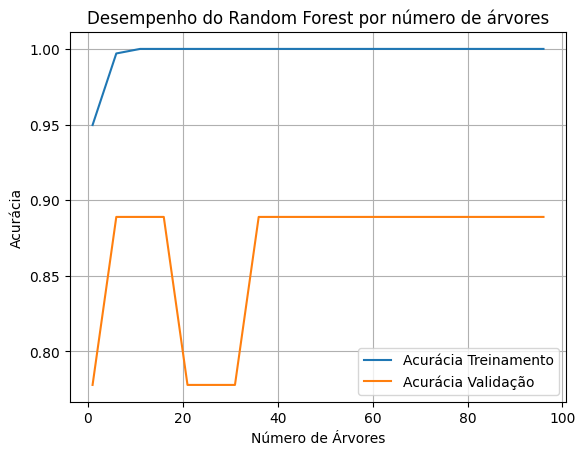

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_arvores = range(1, 100, 5)  # de 1 até 100 árvores, de 5 em 5
train_acc = []
val_acc = []

for n in n_arvores:
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    val_acc.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(n_arvores, train_acc, label='Acurácia Treinamento')
plt.plot(n_arvores, val_acc, label='Acurácia Validação')
plt.xlabel('Número de Árvores')
plt.ylabel('Acurácia')
plt.title('Desempenho do Random Forest por número de árvores')
plt.legend()
plt.grid(True)
plt.show()

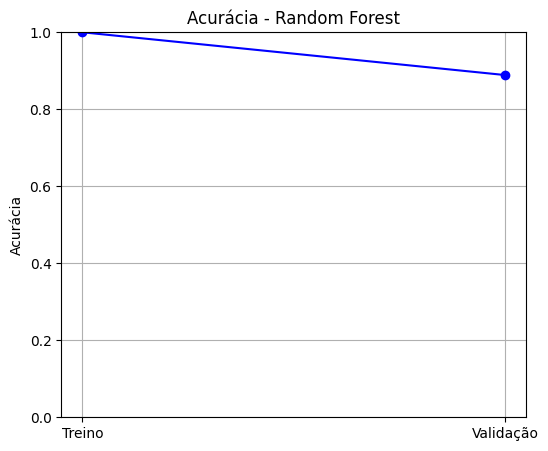

Acurácia Treino: 1.0000
Acurácia Teste : 0.8889


In [16]:
# Avaliação numérica
train_accuracy = clf.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)

# Gráfico de linha com dois pontos: treino e validação
plt.figure(figsize=(6, 5))
plt.plot(['Treino', 'Validação'], [train_accuracy, test_accuracy], marker='o', color='blue')
plt.ylim(0, 1)
plt.ylabel('Acurácia')
plt.title('Acurácia - Random Forest')
plt.grid(True)
plt.show()

# Print para confirmação
print(f'Acurácia Treino: {train_accuracy:.4f}')
print(f'Acurácia Teste : {test_accuracy:.4f}')

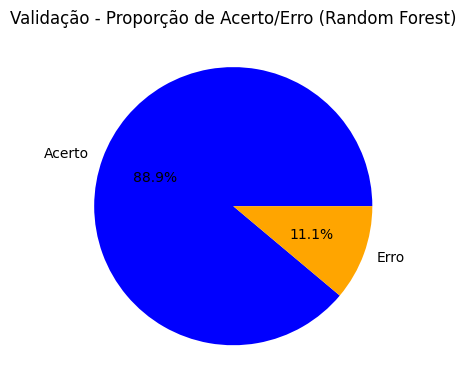

In [22]:
def avaliar_random_forest_pizza(val_acc):
    labels = ['Acerto', 'Erro']
    sizes_val = [val_acc, 1 - val_acc]

    plt.figure(figsize=(4, 4))
    plt.pie(sizes_val, labels=labels, autopct='%1.1f%%', colors=['blue', 'orange'])
    plt.title('Validação - Proporção de Acerto/Erro (Random Forest)')
    plt.tight_layout()
    plt.show()

# Exemplo de uso:
avaliar_random_forest_pizza(rf_val_acc)